# Modeling Procedure 

In principle, the neural network could be defined by graphs consist of tensors and trained through automatic differenciate.

However, for simplification, we recommend to use high-level Keras API in Tensorflow to implement the neural networks.

The common procedures of implementing neural networks using TensorFlow are:

1. Data preparation and loading
2. Model definition
3. Model training
4. Model evaluation, application and saving

In [2]:
import sys
import os
project_path = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_path)
import numpy as np
import pandas as pd
import datetime
import re,string

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models,layers
from tensorflow.keras import models,layers,losses,metrics,callbacks 

from utils.dataset_loader import load_cifar10,get_temporal_sequences_dataset,get_txt_dataset_from_csv,structured_data_preprocessing,get_dataset_from_list_files
from utils.trainer import plot_metric
from backbone.cnn import CNN_3L, Sequential_CNN_3L

In [3]:
# 1 Dataset and dataloader
df = pd.read_csv("../../data/covid-19.csv",sep = "\t")
ds_train, dfdiff= get_temporal_sequences_dataset(df,WINDOW_SIZE = 8)
for x,y in ds_train.take(1): # ds_train = (x_train , y_train)
    print(x.shape,y.shape)

# 2 Model definition (Sequential, Model(Input,Output))
tf.keras.backend.clear_session()
#We design the following block since the daily increment of confirmed, discharged and deceased cases are equal or larger than zero.
class Block(layers.Layer):
    def __init__(self, **kwargs):
        super(Block, self).__init__(**kwargs)
    
    def call(self, x_input,x):
        x_out = tf.maximum((1+x)*x_input[:,-1,:],0.0)
        return x_out
    
    def get_config(self):  
        config = super(Block, self).get_config()
        return config

tf.keras.backend.clear_session()
x_input = layers.Input(shape = (None,3),dtype = tf.float32)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x_input)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x)
x = layers.LSTM(3,input_shape=(None,3))(x)
x = layers.Dense(3)(x)

#We design the following block since the daily increment of confirmed, discharged and deseased cases are equal or larger than zero.
#x = tf.maximum((1+x)*x_input[:,-1,:],0.0)
x = Block()(x_input,x)
model = models.Model(inputs = [x_input],outputs = [x])

# 3 Set optimizer and training
#Customized loss function, consider the ratio between square error and the prediction
class MSPE(losses.Loss):
    def call(self,y_true,y_pred):
        err_percent = (y_true - y_pred)**2/(tf.maximum(y_true**2,1e-7))
        mean_err_percent = tf.reduce_mean(err_percent)
        return mean_err_percent
    
    def get_config(self):
        config = super(MSPE, self).get_config()
        return config

model.compile(optimizer="adam", loss=MSPE(name = "MSPE"))  # no metric ?

stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join('data', 'autograph', stamp)
tb_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
#Half the learning rate if loss is not improved after 100 epoches
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",factor = 0.5, patience = 100)
#Stop training when loss is not improved after 200 epoches
stop_callback = tf.keras.callbacks.EarlyStopping(monitor = "loss", patience= 200)
callbacks_list = [tb_callback,lr_callback,stop_callback]

history = model.fit(ds_train, epochs=500, # no ds_test 
                    callbacks = callbacks_list)   # no ,workers = 4
model.summary()

# 4 Model evaluation, application and saving

(38, 8, 3) (38, 3)
Epoch 1/500
1/1 [==============================] - 0s 165ms/step - loss: 3.5864
Epoch 2/500
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1/1 [==============================] - 0s 14ms/step - loss: 3.5384
Epoch 3/500
1/1 [==============================] - 0s 13ms/step - loss: 3.4905
Epoch 4/500
1/1 [==============================] - 0s 12ms/step - loss: 3.4427
Epoch 5/500
1/1 [==============================] - 0s 10ms/step - loss: 3.3952
Epoch 6/500
1/1 [==============================] - 0s 13ms/step - loss: 3.3478
Epoch 7/500
1/1 [==============================] - 0s 13ms/step - loss: 3.3005
Epoch 8/500
1/1 [==============================] - 0s 13ms/step - loss: 3.2535
Epoch 9/500
1/1 [==============================] - 0s 11ms/step - loss: 3.2067
Epoch 10/500
1/1 [==============================] - 0s 13ms/step - loss: 3.1601
Epoch 11/500
1/1 [==============================] - 0s 9ms/step - loss: 3.1136
Epoch 12/500
1/1 [====================

1/1 [==============================] - 0s 11ms/step - loss: 0.4344
Epoch 100/500
1/1 [==============================] - 0s 10ms/step - loss: 0.4283
Epoch 101/500
1/1 [==============================] - 0s 14ms/step - loss: 0.4226
Epoch 102/500
1/1 [==============================] - 0s 11ms/step - loss: 0.4173
Epoch 103/500
1/1 [==============================] - 0s 10ms/step - loss: 0.4123
Epoch 104/500
1/1 [==============================] - 0s 14ms/step - loss: 0.4077
Epoch 105/500
1/1 [==============================] - 0s 12ms/step - loss: 0.4034
Epoch 106/500
1/1 [==============================] - 0s 13ms/step - loss: 0.3994
Epoch 107/500
1/1 [==============================] - 0s 48ms/step - loss: 0.3957
Epoch 108/500
1/1 [==============================] - 0s 12ms/step - loss: 0.3923
Epoch 109/500
1/1 [==============================] - 0s 12ms/step - loss: 0.3891
Epoch 110/500
1/1 [==============================] - 0s 11ms/step - loss: 0.3862
Epoch 111/500
1/1 [=======================

1/1 [==============================] - 0s 9ms/step - loss: 0.3257
Epoch 201/500
1/1 [==============================] - 0s 9ms/step - loss: 0.3255
Epoch 202/500
1/1 [==============================] - 0s 8ms/step - loss: 0.3253
Epoch 203/500
1/1 [==============================] - 0s 8ms/step - loss: 0.3251
Epoch 204/500
1/1 [==============================] - 0s 8ms/step - loss: 0.3249
Epoch 205/500
1/1 [==============================] - 0s 8ms/step - loss: 0.3247
Epoch 206/500
1/1 [==============================] - 0s 8ms/step - loss: 0.3245
Epoch 207/500
1/1 [==============================] - 0s 8ms/step - loss: 0.3243
Epoch 208/500
1/1 [==============================] - 0s 8ms/step - loss: 0.3241
Epoch 209/500
1/1 [==============================] - 0s 8ms/step - loss: 0.3239
Epoch 210/500
1/1 [==============================] - 0s 7ms/step - loss: 0.3237
Epoch 211/500
1/1 [==============================] - 0s 8ms/step - loss: 0.3235
Epoch 212/500
1/1 [==============================] - 0

1/1 [==============================] - 0s 7ms/step - loss: 0.3099
Epoch 303/500
1/1 [==============================] - 0s 7ms/step - loss: 0.3098
Epoch 304/500
1/1 [==============================] - 0s 7ms/step - loss: 0.3097
Epoch 305/500
1/1 [==============================] - 0s 8ms/step - loss: 0.3095
Epoch 306/500
1/1 [==============================] - 0s 6ms/step - loss: 0.3094
Epoch 307/500
1/1 [==============================] - 0s 6ms/step - loss: 0.3093
Epoch 308/500
1/1 [==============================] - 0s 6ms/step - loss: 0.3091
Epoch 309/500
1/1 [==============================] - 0s 6ms/step - loss: 0.3090
Epoch 310/500
1/1 [==============================] - 0s 6ms/step - loss: 0.3089
Epoch 311/500
1/1 [==============================] - 0s 6ms/step - loss: 0.3087
Epoch 312/500
1/1 [==============================] - 0s 6ms/step - loss: 0.3086
Epoch 313/500
1/1 [==============================] - 0s 6ms/step - loss: 0.3085
Epoch 314/500
1/1 [==============================] - 0

1/1 [==============================] - 0s 7ms/step - loss: 0.2976
Epoch 405/500
1/1 [==============================] - 0s 7ms/step - loss: 0.2975
Epoch 406/500
1/1 [==============================] - 0s 8ms/step - loss: 0.2974
Epoch 407/500
1/1 [==============================] - 0s 8ms/step - loss: 0.2973
Epoch 408/500
1/1 [==============================] - 0s 8ms/step - loss: 0.2972
Epoch 409/500
1/1 [==============================] - 0s 7ms/step - loss: 0.2971
Epoch 410/500
1/1 [==============================] - 0s 8ms/step - loss: 0.2970
Epoch 411/500
1/1 [==============================] - 0s 8ms/step - loss: 0.2969
Epoch 412/500
1/1 [==============================] - 0s 8ms/step - loss: 0.2968
Epoch 413/500
1/1 [==============================] - 0s 8ms/step - loss: 0.2967
Epoch 414/500
1/1 [==============================] - 0s 7ms/step - loss: 0.2966
Epoch 415/500
1/1 [==============================] - 0s 7ms/step - loss: 0.2965
Epoch 416/500
1/1 [==============================] - 0

In [16]:
## 4.3 Model saving
model.save('../../model_saved/temporal_sequence_data_keras_model.model') 
del model  #Deleting current model
model = models.load_model('../../model_saved/temporal_sequence_data_keras_model.model',compile=False)
model.compile(optimizer="adam",loss=MSPE(name = "MSPE"))
model.predict(ds_train)
# Could also model.to_json/models.model_from_json to save structure
# Could also model.save_weights, and save ckpt in save_format = "tf"

INFO:tensorflow:Assets written to: ../../model_saved/temporal_sequence_data_keras_model.model/assets


array([[1.0257219e+03, 9.3611313e+01, 2.8358908e+00],
       [1.2651711e+03, 7.3399780e+01, 5.7663112e+00],
       [1.3804976e+03, 1.5637344e+02, 5.3881922e+00],
       [1.5798756e+03, 1.6701109e+02, 6.0499001e+00],
       [1.8989783e+03, 2.7657889e+02, 6.1444297e+00],
       [1.8051533e+03, 2.7764264e+02, 6.9006672e+00],
       [1.5358953e+03, 4.1167703e+02, 6.9006672e+00],
       [1.6541538e+03, 5.4252014e+02, 8.1295528e+00],
       [1.2959574e+03, 6.3719519e+02, 8.4131422e+00],
       [1.4528210e+03, 6.7229944e+02, 9.1693802e+00],
       [1.2055531e+03, 7.6059192e+02, 1.0209207e+01],
       [9.8467352e+02, 7.9144110e+02, 9.1693802e+00],
       [7.4038652e+03, 1.2456687e+03, 2.4010540e+01],
       [1.9776544e+03, 8.6377710e+02, 1.2288859e+00],
       [1.2953982e+03, 1.4571327e+03, 1.4704596e+01],
       [9.9165070e+02, 1.4020712e+03, 1.6026682e+01],
       [1.0168446e+03, 1.5118494e+03, 1.2248386e+01],
       [9.4106207e+02, 1.8141437e+03, 1.1639174e+01],
       [8.7500208e+02, 1.937

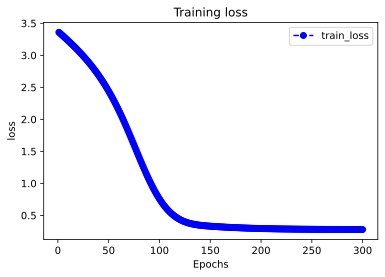

In [10]:
# 4 Model evaluation, application and saving
## 4.1 Model evaluate 
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.title('Training '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric])
    plt.show()

plot_metric(history,"loss")

In [4]:
##4.2 Model Application
#This "dfresult" is used to record the current and predicted data
dfresult = dfdiff[["confirmed_num","cured_num","dead_num"]].copy()
dfresult.tail()

,confirmed_num,cured_num,dead_num
41,143.0,1681.0,30.0
42,99.0,1678.0,28.0
43,44.0,1661.0,27.0
44,40.0,1535.0,22.0
45,19.0,1297.0,17.0


In [5]:
#Predicting the daily increment of the new confirmed cases of the next 100 days; add this result into dfresult
for i in range(100):
    arr_predict = model.predict(tf.constant(tf.expand_dims(dfresult.values[-38:,:],axis = 0)))

    dfpredict = pd.DataFrame(tf.cast(tf.floor(arr_predict),tf.float32).numpy(),
                columns = dfresult.columns)
    dfresult = dfresult.append(dfpredict,ignore_index=True)

In [6]:
dfresult.query("confirmed_num==0").head()

# From Day 55 the daily increment of the new confirmed cases reduced to zero. Since Day 45 is corresponding to March 10, the daily increment of the news confirmed cases will reduce to 0 in Manch 20.
# Note: this prediction is TOO optimistic

,confirmed_num,cured_num,dead_num
48,0.0,934.0,0.0
49,0.0,804.0,0.0
50,0.0,680.0,0.0
51,0.0,565.0,0.0
52,0.0,461.0,0.0


In [7]:
dfresult.query("cured_num==0").head()

# The daily increment of the discharged (cured) cases will reduce to 0 in Day 164, which is about 4 months after March 10 (i.e. July 10) all the patients will be discharged.
# Note: this prediction is TOO pessimistic and problematic: the total sum of the daily increment of discharged cases is larger than cumulated confirmed cases.

,confirmed_num,cured_num,dead_num
74,0.0,0.0,0.0
75,0.0,0.0,0.0
76,0.0,0.0,0.0
77,0.0,0.0,0.0
78,0.0,0.0,0.0


In [8]:
dfresult.query("dead_num==0").head()

# The daily increment of the deceased will be reduced to 0 from Day 60, which is March 25, 2020
# Note: This prediction is relatively reasonable.

,confirmed_num,cured_num,dead_num
46,4.0,1186.0,0.0
47,1.0,1063.0,0.0
48,0.0,934.0,0.0
49,0.0,804.0,0.0
50,0.0,680.0,0.0
